# Modelo de Procesamiento de Datos de Movimiento

Autores: 

-Juan Sebastián Cely Botia

-Juan Carlos Ceron Lombana

-Juan Diego Díaz Guzmán
    
## Introducción

El modelo consiste en la captura y el procesamiento de datos de movimiento a partir de un dispositivo móvil para desarrollar un modelo de inteligencia artificial con capacidades de clasificación.

## Marco Teórico

// Incluir marco teórico relacionado con el caso de estudio

## Descripción del problema a solucionar

Se pretende desarrollar un modelo de inteligencia artificial mediante redes neuronales que sea capaz de clasificar correctamente datos de movimiento capturados con un acelerómetro de un teléfono móvil para los siguientes movimientos: corriendo, caminando, reposo, arriba, abajo, ola, izquierda y derecha. Se pretende entrenar el modelo con las series de coordenadas espaciales etiquetadas y comprobar su precisión mediante métricas establecidas. 

## Planteamiento de la solución

In [7]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor


### Importar datos del objeto JSON

In [8]:
# Cargar datos desde el archivo JSON
path = '../data/motion/arriba-jc (1).json' # Path par aGitHub
# path = '' # Path para Google Colab

with open(path, 'r') as file:
    datos_json = json.load(file)

# Extraer los valores de los sensores
valores_sensores = datos_json['payload']['values']

print("Valores de los sensores:")
print(valores_sensores)

Valores de los sensores:
[[0.2326864921127446, -9.016863311877847, -3.768922033636272], [0.16325461656874976, -8.921244883075357, -3.962253525432944], [0.09501993318637833, -8.98873261141479, -3.7325603881835936], [0.09501993318637833, -8.98873261141479, -3.7325603881835936], [0.17492639532778412, -9.010278672790527, -3.6089588506951924], [0.20739768227841704, -8.992622020068763, -3.545513091222942], [0.21173724585268644, -8.97676043407023, -3.5872616904109713], [0.3516484053680673, -8.986337240710855, -3.637240650066733], [0.34536353467861186, -8.926182339477538, -3.694252284838259], [0.27219072817377743, -8.959551525115966, -3.6457699934810397], [0.14844044813076032, -8.971522533416747, -3.5380306265130637], [0.08768762667006813, -8.97661021194458, -3.4674016775384544], [0.023044209245312957, -8.980651011767982, -3.5432679426446554], [0.12120649557802825, -8.95162014759481, -3.8051337492242454], [-0.08319854422304779, -8.876652292633056, -3.933672743114829], [0.08020577388154343, -8.

### Visualización de datos iniciales

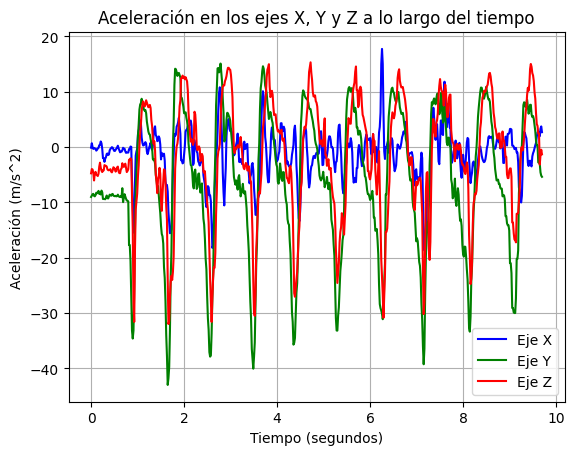

In [233]:
# Obtener los valores de la aceleración en el eje X, Y y Z
valores_x = [dato[0] for dato in valores_sensores]
valores_y = [dato[1] for dato in valores_sensores]
valores_z = [dato[2] for dato in valores_sensores]

# Crear una lista de tiempos para cada punto de datos
# Suponiendo que los datos se registraron a intervalos regulares de 16 ms
tiempos = [i * 0.016 for i in range(len(valores_x))]

# Trazar los valores de la aceleración en el eje X, Y y Z con respecto al tiempo
plt.plot(tiempos, valores_x, label='Eje X', color='blue')
plt.plot(tiempos, valores_y, label='Eje Y', color='green')
plt.plot(tiempos, valores_z, label='Eje Z', color='red')

plt.xlabel('Tiempo (segundos)')
plt.ylabel('Aceleración (m/s^2)')
plt.title('Aceleración en los ejes X, Y y Z a lo largo del tiempo')
plt.grid(True)
plt.legend()
plt.show()


### Análisis de patrones de movimiento

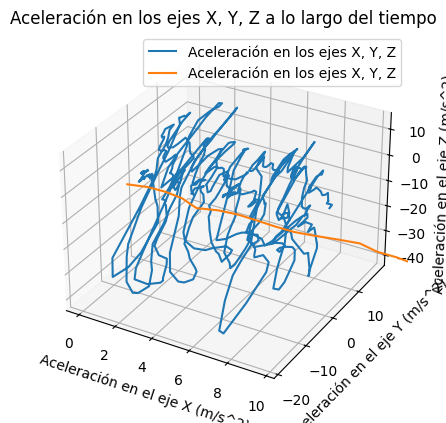

In [97]:

# Obtener los valores de aceleración en los ejes X, Y, Z
valores_x = [dato[0] for dato in valores_sensores]
valores_y = [dato[1] for dato in valores_sensores]
valores_z = [dato[2] for dato in valores_sensores]

# Crear una lista de tiempos para cada punto de datos
# intervalos regulares de 16 ms
tiempos = [i * 0.016 for i in range(len(valores_x))]

# Trazar la aceleración en los ejes X, Y, Z en una gráfica tridimensional
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(tiempos, valores_x, valores_y, valores_z, label='Aceleración en los ejes X, Y, Z')
ax.set_xlabel('Aceleración en el eje X (m/s^2)')
ax.set_ylabel('Aceleración en el eje Y (m/s^2)')
ax.set_zlabel('Aceleración en el eje Z (m/s^2)')
plt.title('Aceleración en los ejes X, Y, Z a lo largo del tiempo')
plt.grid(True)
plt.legend()
plt.show()

## Preparar los datos

In [98]:
valores_sensores = list(zip(valores_x, valores_y, valores_z))
datos = np.array(valores_sensores)  

## Escalar los datos

In [99]:
scaler = MinMaxScaler()
datos_escalados = scaler.fit_transform(datos)

## Visualizar los datos escalados


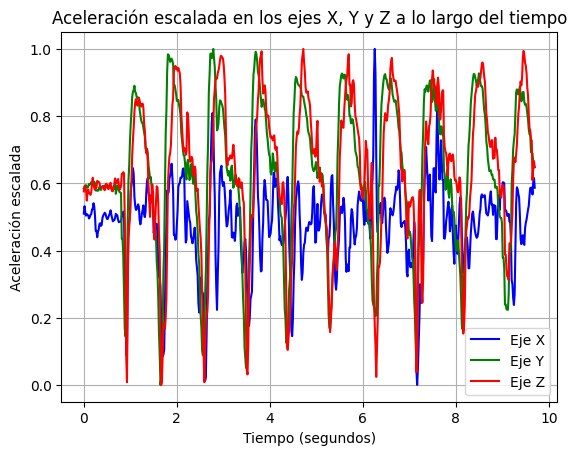

In [85]:
# Descomponer los datos escalados por eje para su visualización
datos_x_escalados = datos_escalados[:, 0]
datos_y_escalados = datos_escalados[:, 1]
datos_z_escalados = datos_escalados[:, 2]

# Crear los tiempos para cada punto de datos
tiempos = [i * 0.016 for i in range(len(datos_x_escalados))]

# Trazar los valores de la aceleración escalados en el eje X, Y y Z con respecto al tiempo
plt.plot(tiempos, datos_x_escalados, label='Eje X', color='blue')
plt.plot(tiempos, datos_y_escalados, label='Eje Y', color='green')
plt.plot(tiempos, datos_z_escalados, label='Eje Z', color='red')

plt.xlabel('Tiempo (segundos)')
plt.ylabel('Aceleración escalada')
plt.title('Aceleración escalada en los ejes X, Y y Z a lo largo del tiempo')
plt.grid(True)
plt.legend()
plt.show()


In [167]:
#Definir los patametros de la ventana

tamaño_ventana = 10  # Por ejemplo, 10 mediciones consecutivas
paso_ventana = 1     # Cada ventana comienza 1 paso después de la anterior


In [168]:
#Creación de las ventanas

def crear_ventanas(datos, tamaño_ventana, paso_ventana):
    X = []
    n_muestras = len(datos) - tamaño_ventana + 1
    for inicio in range(0, n_muestras, paso_ventana):
        fin = inicio + tamaño_ventana
        ventana = datos[inicio:fin]
        X.append(ventana)
    return np.array(X)

In [169]:
# Aplicar la función a los Datos simulados
valores_x = np.random.rand(100)
valores_y = np.random.rand(100)
valores_z = np.random.rand(100)

# Combinar en un único array de (n_muestras, n_canales)
datos = np.column_stack((valores_x, valores_y, valores_z))

# Crear ventanas
X_train = crear_ventanas(datos, tamaño_ventana, paso_ventana)

In [170]:
#Verificar las dimensiones

print("Forma de la entrada de entrenamiento:", X_train.shape)
# Deberías obtener algo como (91, 10, 3) si hay 100 datos y usas ventanas de tamaño 10 con paso 1


Forma de la entrada de entrenamiento: (91, 10, 3)


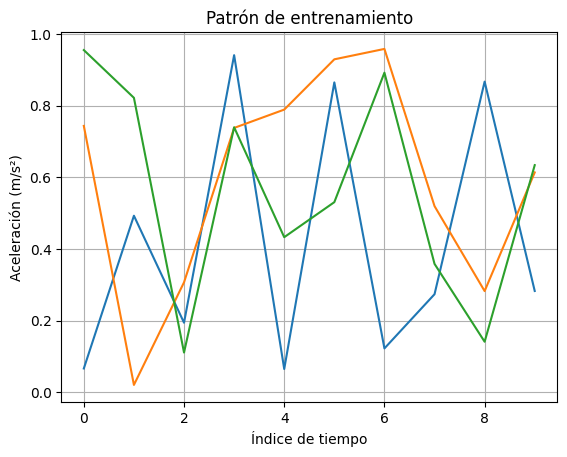

In [172]:
#Visualizar patrón de entrenamiento

# Visualizar la muestra número 10 del conjunto de entrenamiento
plt.plot(X_train[10,:,:])
plt.xlabel('Índice de tiempo')
plt.ylabel('Aceleración (m/s²)')
plt.title('Patrón de entrenamiento')
plt.grid(True)
plt.show()

## Modelo basado en MLP

In [197]:
labels = np.random.rand(X_train.shape[0])  # Generar etiquetas aleatorias para este ejemplo

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_train, labels, test_size=0.2, random_state=42)

# Definir el modelo MLP
model = MLPRegressor(hidden_layer_sizes=(100, 50),  
                     activation='relu',            
                     solver='adam',                
                     max_iter=1000,                
                     random_state=42)              

# Entrenar el modelo
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)


Error cuadrático medio: 0.17783617853476844


## Optimización de Hiperparametros

In [198]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}



In [199]:
#Utilizar RandomizedSearchCV
# Definir el modelo MLPRegressor
model = MLPRegressor(max_iter=1000, random_state=42)

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, random_state=42)

# Realizar la búsqueda aleatoria
random_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)


Mejores hiperparámetros encontrados:
{'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'logistic'}


## Refinamiento del Modelo

In [200]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Definir un nuevo modelo MLPRegressor con las funciones de activación 'relu'
refined_model = MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', alpha=0.001, learning_rate='adaptive', max_iter=1000, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
refined_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_refined = refined_model.predict(X_test.reshape(X_test.shape[0], -1))

# Calcular el error cuadrático medio
mse_refined = mean_squared_error(y_test, y_pred_refined)
print("Error cuadrático medio con la función de activación 'relu' mejorado:", mse_refined)



Error cuadrático medio con la función de activación 'relu' mejorado: 0.1726119481103885


## Modelo de Convolución en 1D

In [204]:
# Definir las variables longitud_secuencia y numero_canales
longitud_secuencia = X_train.shape[1]  # Longitud de la secuencia
numero_canales = X_train.shape[2]      # Número de canales

# Inicializar el modelo secuencial
model = Sequential()

# Agregar una capa de entrada con las dimensiones adecuadas
model.add(Input(shape=(longitud_secuencia, numero_canales)))

# Agregar una capa de convolución 1D
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Agregar una capa de pooling
model.add(MaxPooling1D(pool_size=2))

# Agregar una capa de aplanado
model.add(Flatten())

# Agregar una capa densa para la salida
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Capa de salida para regresión


## Compilación del Modelo

In [210]:


model.compile(optimizer='adam', loss='mse')  # Uso de  'adam' como optimizador y 'mse' como función de pérdida


## Entrenamiento del Modelo

In [211]:


model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step - loss: 0.0673 - val_loss: 0.0767
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0640 - val_loss: 0.0753
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0631 - val_loss: 0.0765
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0602 - val_loss: 0.0791
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0577 - val_loss: 0.0823
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0563 - val_loss: 0.0839
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0547 - val_loss: 0.0832
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0528 - val_loss: 0.0819
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0511 - val_loss: 0.0815
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0497 - val_loss: 0.0820


## Evaluación del Modelo


In [208]:

mse = model.evaluate(X_test, y_test)  # Calcular el error cuadrático medio en el conjunto de prueba
print("Error cuadrático medio:", mse)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0785
Error cuadrático medio: 0.07848961651325226


## Resultados

// Espacio para el análisis de los resultados obtenidos

## Referencias

// Incluir referencias encontradas